# 🍒 Fruit Ninja Robot 🍑

## Program and Simulation Setup

In [ ]:
# Imports, imports everywhere
# Balance of Trade = Value of Exports - Value of Imports... - Abraham Lincoln, probably
import numpy as np
import time 
import threading
import random 
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from copy import deepcopy

from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    ConstantVectorSource,
    DiagramBuilder,
    MeshcatVisualizer,
    MeshcatVisualizerParams,
    MultibodyPlant,
    Parser,
    PiecewisePolynomial,
    PiecewiseQuaternionSlerp,
    RigidTransform,
    RollPitchYaw,
    RotationMatrix,
    Simulator,
    Solve,
    StartMeshcat,
    TrajectorySource,
    
    KinematicTrajectoryOptimization,
    BsplineTrajectory,
    MeshcatVisualizer,
    MeshcatVisualizerParams,
    PositionConstraint,
    OrientationConstraint,
    Role,
    JacobianWrtVariable,
    
    Sphere,
    Rgba,
    PointCloud,
    LeafSystem,
    EventStatus,
    AbstractValue,
    Event,
    ImageRgba8U, 
    ImageDepth32F
)

from pydrake.multibody import inverse_kinematics
from pydrake.trajectories import PiecewisePolynomial
from pydrake.perception import DepthImageToPointCloud

from manipulation.meshcat_utils import AddMeshcatTriad, PublishPositionTrajectory
from manipulation.scenarios import AddMultibodyTriad, AddPlanarIiwa, AddIiwa, AddShape, AddWsg
from manipulation.utils import running_as_notebook
from manipulation.station import load_scenario, MakeHardwareStation, AddPointClouds

import time

In [ ]:
# Start the visualizer.
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at https://f7bf94ae-48b6-4da0-b037-4d9acdec7e95.deepnoteproject.com/7000/


## Scenario Models Setup

In [ ]:
# Add elements to the scene. Not quite sure how this format works yet...
katana_filename = "/work/katana.sdf"
sphere_filename = "/work/sphere_modified.sdf"
red_sphere_filename = "/work/red_sphere.sdf"
green_sphere_filename = "/work/green_sphere.sdf"
blue_sphere_filename = "/work/blue_sphere.sdf"
half_sphere_filename = "/work/halfsphere2.sdf"
colors = ["green", "yellow", "red", "blue", "black"]
fruit_filenames = [("/work/half_"+c+"1.sdf", "/work/half_"+c+"2.sdf") for c in colors]
half_black1_filename = "/work/half_black1.sdf"
half_blue1_filename = "/work/half_blue1.sdf"
half_red1_filename = "/work/half_red1.sdf"
half_red1_filename = "/work/half_red1.sdf"
half_yellow1_filename = "/work/half_yellow1.sdf"
half_black2_filename = "/work/half_black2.sdf"
half_blue2_filename = "/work/half_blue2.sdf"
half_green1_filename = "/work/half_green1.sdf"
half_green2_filename = "/work/half_green2.sdf"
half_red2_filename = "/work/half_red2.sdf"
half_yellow2_filename = "/work/half_yellow2.sdf"
colors = ["green", "yellow", "red", "blue", "black"]
fruit_filenames = [("/work/half_"+c+"1.sdf", "/work/half_"+c+"2.sdf") for c in colors]

fgp_x, fgp_y, fgp_z = 0, 2.5, 0.4
fruit_generation_point = [fgp_x, fgp_y, fgp_z]  # 5 meters in front of the robot, aligned horizontally and vertically
top_view_camera_position = [fgp_x, fgp_y/2, 2]  # Halfway between the robot and FGP, at a height of 2 meters
side_view_camera_position = [fgp_x-1, fgp_y/2, fgp_z]  # To the side, halfway between robot and FGP
red_position_left_corner = [fgp_x + 0.535, fgp_y/2 + 0.402, 1];
red_position = [0.1, 1.3, 0.3];
top_camera_rotation = [0, 180, 0]
rotation_rpy = RollPitchYaw(np.radians(top_camera_rotation))
X_WC = RigidTransform(rotation_rpy, top_view_camera_position)
# # put spheres in the camera's view to test
# spheres = [
#     {"name": "sphere_red", "color": Rgba(1, 0, 0, 1), "size": 0.05, "position": [fgp_x, fgp_y - 1, fgp_z]},
#     {"name": "sphere_green", "color": Rgba(0, 1, 0, 1), "size": 0.1, "position": [fgp_x, fgp_y - 2, fgp_z]},
#     {"name": "sphere_blue", "color": Rgba(0, 0, 1, 1), "size": 0.15, "position": [fgp_x, fgp_y - 3, fgp_z]}
# ]

scenario_data_no_ballz = f"""
directives:
- add_model:
    name: iiwa
    file: package://drake/manipulation/models/iiwa_description/iiwa7/iiwa7_no_collision.sdf
    default_joint_positions:
        iiwa_joint_1: [0]
        iiwa_joint_2: [0.1]
        iiwa_joint_3: [0]
        iiwa_joint_4: [-1.2]
        iiwa_joint_5: [0]
        iiwa_joint_6: [1.6]
        iiwa_joint_7: [0]
- add_weld:
    parent: world
    child: iiwa::iiwa_link_0

- add_model:
    name: katana
    file: file://{katana_filename}
- add_weld:   
    parent: iiwa::iiwa_link_7
    child: katana::katana
    X_PC:
        translation: [-0.34, 0.00, 0.05]
        rotation: !Rpy {{ deg: [0, -90, -90] }}

model_drivers:
    iiwa: !IiwaDriver
      hand_model_name: none
"""

scenario_data = f"""
directives:
- add_model:
    name: iiwa
    file: package://drake/manipulation/models/iiwa_description/iiwa7/iiwa7_no_collision.sdf
    default_joint_positions:
        iiwa_joint_1: [0]
        iiwa_joint_2: [0.1]
        iiwa_joint_3: [0]
        iiwa_joint_4: [-1.2]
        iiwa_joint_5: [0]
        iiwa_joint_6: [1.6]
        iiwa_joint_7: [0]
- add_weld:
    parent: world
    child: iiwa::iiwa_link_0

- add_model:
    name: katana
    file: file://{katana_filename}
- add_weld:   
    parent: iiwa::iiwa_link_7
    child: katana::katana
    X_PC:
        translation: [-0.34, 0.00, 0.05]
        rotation: !Rpy {{ deg: [0, -90, -90] }}

- add_model:
    name: half_green1
    file: file://{half_green1_filename}
- add_model:
    name: half_green2
    file: file://{half_green2_filename}

- add_model:
    name: camera_top_view
    file: package://manipulation/camera_box.sdf
- add_weld:
    parent: world
    child: camera_top_view::base
    X_PC:
        translation: {top_view_camera_position}
        rotation: !Rpy {{ deg: {top_camera_rotation} }}  # Pointing downwards

- add_model:
    name: camera_side_view
    file: package://manipulation/camera_box.sdf
- add_weld:
    parent: world
    child: camera_side_view::base
    X_PC:
        translation: {side_view_camera_position}
        rotation: !Rpy {{ deg: [-90, 0, -90] }}  # Pointing towards the FGP
- add_model:
    name: fgp_marker
    file: file://{sphere_filename}
- add_weld:
    parent: world
    child: fgp_marker::link
    
cameras:
    top_view_camera:
        name: camera0
        depth: True
        X_PB:
            base_frame: camera_top_view::base
    side_view_camera:
        name: camera1
        depth: True
        X_PB:
            base_frame: camera_side_view::base

model_drivers:
    iiwa: !IiwaDriver
      hand_model_name: none

visualization:
    publish_contacts: True
"""

scenario = load_scenario(data=scenario_data)
scenario_no_ballz = load_scenario(data=scenario_data_no_ballz)

## Robot Setup

In [ ]:
# Create a wrapper class to control the IIWA arm.
class Ninja:
    def __init__(self, scenario, meshcat):
        """
        Initializate function robot ninja object. Honestly, this doesn't really do much...

        @param scenario: scene scenario string with object .sdf files.
        @param meshcat: meshcat object for simulation.
        """
        self.scenario = scenario
        self.meshcat = meshcat

        self.builder = None
        self.station = None
        self.plant = None

    def create_kinematic_trajectory(self, trajectory, num_control_points=10, traj_duration_bounds=[0.5,5], max_tries=5):
        """
        Create a trajectory that contains all the RigidTransforms in trajectory through 
        KinematicTrajectoryOptimization. 

        @param trajectory: dictionary of rigid transforms and orientation boolans, 
               trajectory["poses"][i] should contain keyframe X_WG at index i, and
               trajectory["orientation_constraints"][i] should contain True if keyframe 
               X_WG needs an orientation constraint.
        @param num_control_points: number of points in the trajectory, I think...
        @param traj_duration_bounds: upper and lower limit for how long following the trajectory should take.
        @param max_tries: maximum number of attempts to solve mathematical program
        """
        # set up the optimization problem and add general costs and constraints for 
        # time, path length, etc.
        self.plant_root_context = self.plant.GetMyContextFromRoot(self.diagram_context)
        num_q = self.plant.num_positions()
        q0 = self.plant.GetPositions(self.plant_root_context)

        trajopt = KinematicTrajectoryOptimization(num_q, num_control_points)
        prog = trajopt.get_mutable_prog()

        trajopt.AddDurationCost(1.0)
        trajopt.AddPathLengthCost(1.0)
        trajopt.AddPositionBounds(self.plant.GetPositionLowerLimits(), self.plant.GetPositionUpperLimits())
        trajopt.AddDurationConstraint(traj_duration_bounds[0], traj_duration_bounds[1])

        cut_pose_indices = []
        
        # for every rigid transform in trajectory["poses"], add a position constraint and cost so that the solver
        # tries to move the trajectory through each pose.
        for i in range(len(trajectory["poses"])):

            # transform each pose by length of katana along particular axis
            pose = trajectory["poses"][i]
            pos_constraint = PositionConstraint(
                self.plant,
                self.world_frame,
                pose.translation() - np.array([0.5, 0.01, 0.01]),
                pose.translation() + np.array([0.3, 0.01, 0.01]),
                self.katana_frame, 
                [0.0, 0.0, 0.0],
                self.plant_root_context
            )
            # maybe add velocity constraint for fruit point
            trajopt.AddPathPositionConstraint(pos_constraint, i/len(trajectory["poses"]))

            if trajectory["orientation_constraints"][i]:
                orientation_constraint = OrientationConstraint(
                    self.plant,
                    self.world_frame,
                    pose.rotation(),
                    self.katana_frame,
                    RotationMatrix(),
                    np.pi/26,
                    self.plant_root_context
                )
                trajopt.AddPathPositionConstraint(orientation_constraint, i/len(trajectory["poses"]))
                
            if trajectory["types"][i] == CUT_POSE:
                cut_pose_indices.append(i)

            prog.AddQuadraticErrorCost(np.eye(num_q), q0, trajopt.control_points()[:, i])
        
        # add constraints so the trajectory starts and ends with zero velocity hopefully.
        trajopt.AddPathVelocityConstraint(np.zeros((num_q, 1)), np.zeros((num_q, 1)), 0)
        trajopt.AddPathVelocityConstraint(np.zeros((num_q, 1)), np.zeros((num_q, 1)), 1)

        ik = inverse_kinematics.InverseKinematics(self.plant)
        q_nominal = np.array([0.0, 0.6, 0.0, -1.75, 0.0, 1.0, 0.0])
        q_variables = ik.q()
        ik_prog = ik.prog()

        ik_bounds = 0.01
        upper_bound = trajectory["poses"][cut_pose_indices[0]].translation() + [0.3, 0.01, ik_bounds]
        lower_bound = trajectory["poses"][cut_pose_indices[0]].translation() - [0.5, 0.01, ik_bounds]
        ik.AddPositionConstraint(frameA=self.world_frame, frameB=self.katana_frame, p_BQ=np.zeros(3), 
                                 p_AQ_lower=lower_bound, p_AQ_upper=upper_bound)
        ik_prog.SetInitialGuess(q_variables, q_nominal)
        ik_result = Solve(ik_prog)
        ik_success = ik_result.is_success()
        
        if ik_success:
            q_guess = np.tile(q0.reshape((num_q, 1)), (1, trajopt.num_control_points()))
            q_guess[:, cut_pose_indices[0]] = ik_result.GetSolution()
            path_guess = BsplineTrajectory(trajopt.basis(), q_guess)
            trajopt.SetInitialGuess(path_guess)

        success = False
        for count in range(max_tries):
            # Compute a random initial guess here
            result = Solve(prog)
            success = result.is_success()
            if success:
                trajectory = trajopt.ReconstructTrajectory(result)

                time_step = 1.0/35.0
                times = np.append(np.arange(trajectory.start_time(), trajectory.end_time(), time_step), trajectory.end_time())
                traj = np.array([trajectory.value(t) for t in times])
                N = traj.shape
                traj = traj.reshape((N[0], N[1]))
                
                t0 = 0
                return traj, times + t0
            else:
                print(f"{count}: Failed: {result.get_solver_id().name()}...")
                return np.array([]), np.array([])
                
        return np.array([]), np.array([])


    def create_ik_trajectory(self, trajectory, traj_duration_bounds=[0.5,5], max_tries=5):
        """
        Convert end-effector pose list to joint position list using series of InverseKinematics problems. 
        Note that q is 9-dimensional because the last 2 dimensions contain gripper joints, but these should 
        not matter to the constraints.
        
        @param trajectory: dictionary of rigid transforms and orientation boolans, 
               trajectory["poses"][i] should contain keyframe X_WG at index i, and
               trajectory["orientation_constraints"][i] should contain True if keyframe 
               X_WG needs an orientation constraint.
        """
        q_knots = []
        # nominal joint angles for joint-centering
        q_nominal = np.array([0.0, 0.6, 0.0, -1.75, 0.0, 1.0, 0.0])

        for i in range(len(trajectory["poses"])):
            # initialize inverse kinematics optimization problem to minimize the distance between
            # a set of nominal joint angles and joint angles
            ik = inverse_kinematics.InverseKinematics(self.plant)
            q_variables = ik.q()
            prog = ik.prog()

            qd = q_variables - q_nominal
            prog.AddCost(qd.dot(qd))

            # add a position/orientation constraint for every pose in the trajectory so the gripper runs through 
            # to those poses in its trajectory
            ik_bounds = 0.005
            upper_bound = trajectory["poses"][i].translation() + [0, 0, ik_bounds]
            lower_bound = trajectory["poses"][i].translation() + [0, 0, ik_bounds]

            ik.AddPositionConstraint(frameA=self.world_frame, frameB=self.katana_frame, 
                                     p_BQ=np.zeros(3), p_AQ_lower=lower_bound, p_AQ_upper=upper_bound)
            if trajectory["orientation_constraints"][i]:
                ik.AddOrientationConstraint(frameAbar=self.world_frame, R_AbarA=trajectory["poses"][i].rotation(), 
                                            frameBbar=self.katana_frame, R_BbarB=RotationMatrix(), 
                                            theta_bound=np.pi/26)

            success = False
            for count in range(max_tries):
                if i == 0:
                    prog.SetInitialGuess(q_variables, q_nominal)
                else:
                    prog.SetInitialGuess(q_variables, q_knots[-1])

                result = Solve(prog)
                success = result.is_success()
                if success:
                    q_knots.append(result.GetSolution(q_variables))
                    break
                else:
                    print(f"{count}: Failed: {result.get_solver_id().name()}...")

            if not success:
                return np.array([]), np.array([])            

        # build a smooth trajectory out of the solved waypoints
        q_knots = np.array(q_knots)
        traj = q_knots[:, 0:7]
        
        N = traj.shape
        time_step = 1.0/35.0
        # times = np.append(np.arange(0, traj_duration_bounds[0], time_step), traj_duration_bounds[0])
        times = np.arange(0, traj_duration_bounds[0], traj_duration_bounds[0]/N[0])
        #traj = traj.reshape((N[0], N[1]))
        
        t0 = 0
        return traj, times + t0


In [ ]:
START_POSE_COLOR = Rgba(0.9, 0.1, 0.1, 0.5)
END_POSE_COLOR = Rgba(0.1, 0.9, 0.1, 0.5)
PRE_CUT_POSE_COLOR = Rgba(0.1, 0.1, 0.9, 0.5)
CUT_POSE_COLOR = Rgba(0.9, 0.1, 0.9, 0.5)

START_POSE = "START_POSE"
END_POSE = "END_POSE"
PRE_CUT_POSE = "PRE_CUT_POSE"
CUT_POSE = "CUT_POSE"

def render_pose(pose_id, pose, color, show_triad=True):
    return
    if show_triad:
        AddMeshcatTriad(meshcat, path=pose_id, X_PT=pose, opacity=color.a())
    meshcat.SetObject(pose_id, Sphere(0.03), rgba=color)
    meshcat.SetTransform(pose_id, pose)

# create sample trajectory and visualize it.
trajectory_duration = 3
num_trajectory_samples = 5

def create_cut_trajectory(bot, cut_positions):
    trajectory = {
        "poses": [],
        "orientation_constraints": [],
        "types": []
    }

    if not len(cut_positions):
        return trajectory_duration

    t = 0
    p0 = np.array(bot.initial_pose.translation())
    R0 = bot.initial_pose.rotation()
    P0 = RigidTransform(R0, p0)
    
    trajectory["poses"].append(P0)
    trajectory["orientation_constraints"].append(False)
    trajectory["types"].append(START_POSE)
    render_pose(str(t), P0, START_POSE_COLOR, show_triad=trajectory["orientation_constraints"][-1])
    t += 1

    slope = np.zeros(3)
    R = RotationMatrix()

    if len(cut_positions) == 1:
        p = np.array(cut_positions[0])

        slope = p - p0
        flat_slope = np.array([slope[0] * 0.0, slope[1], slope[2]])
        slope = slope/np.linalg.norm(slope)
        flat_slope = flat_slope/np.linalg.norm(flat_slope)

        # Assuming the initial orientation is along the x-axis
        initial_orientation = RollPitchYaw(0, 0, 0)  # No rotation
        initial_rotation_matrix = initial_orientation.ToRotationMatrix()

        # Compute the target orientation based on the direction vector
        # This might involve calculating roll, pitch, and yaw based on the direction vector
        # The exact method depends on how you define the orientation in your problem
        # Assuming roll is zero or set based on your application's needs
        roll = int(p0[1] > p[1]) * np.pi
        pitch = np.arctan2(-slope[2], np.sqrt(slope[0]**2 + slope[1]**2))
        yaw = np.arctan2(slope[1], slope[0])
        target_orientation = RollPitchYaw(roll, pitch, yaw)
        target_rotation_matrix = target_orientation.ToRotationMatrix()
        
        R = initial_rotation_matrix.multiply(target_rotation_matrix)
        
        flat_roll = int(p0[1] > p[1]) * np.pi
        flat_pitch = np.arctan2(-flat_slope[2], np.sqrt(flat_slope[0]**2 + flat_slope[1]**2))
        flat_yaw = np.arctan2(flat_slope[1], flat_slope[0])
        flat_target_orientation = RollPitchYaw(flat_roll, flat_pitch, flat_yaw)
        flat_target_rotation_matrix = flat_target_orientation.ToRotationMatrix()
        
        flat_R = initial_rotation_matrix.multiply(flat_target_rotation_matrix)

        p1 = p - slope * 0.1
        R1 = R
        P1 = RigidTransform(R1, p1)
    elif len(cut_positions) == 2:
        pass
    else:
        pass

    P = RigidTransform(R, cut_positions[0])
    for pos in cut_positions:
        P = RigidTransform(flat_R, pos)

        trajectory["poses"].append(P)
        trajectory["orientation_constraints"].append(True)
        trajectory["types"].append(CUT_POSE)
        render_pose(str(t), P, CUT_POSE_COLOR, show_triad=trajectory["orientation_constraints"][-1])
        t += 1

    finish_pose_dist = 0.25
    pf = np.array(P.translation()) + flat_slope * finish_pose_dist
    Rf = flat_R
    Pf = RigidTransform(Rf, pf)


    trajectory["poses"].append(Pf)
    trajectory["orientation_constraints"].append(True)
    trajectory["types"].append(END_POSE)
    render_pose(str(t), Pf, END_POSE_COLOR, show_triad=trajectory["orientation_constraints"][-1])
    t += 1
    
    return trajectory


Creating ninja!
INFO:drake:Meshcat listening for connections at http://localhost:7001
Created ninja!
Starting trials!

INFO:drake:Meshcat listening for connections at http://localhost:7002
==== LCM Warning ===
LCM detected that large packets are being received, but the kernel UDP
receive buffer is very small.  The possibility of dropping packets due to
insufficient buffer space is very high.

For more information, visit:
   http://lcm-proj.github.io/lcm/multicast_setup.html

KTO Trial #1: [ 0.72311081 -0.34806705  0.76387469]!
KTO solver succeeded in 0.03850913047790527 seconds.
==== LCM Warning ===
LCM detected that large packets are being received, but the kernel UDP
receive buffer is very small.  The possibility of dropping packets due to
insufficient buffer space is very high.

For more information, visit:
   http://lcm-proj.github.io/lcm/multicast_setup.html

KTO successfully hit target!

INFO:drake:Meshcat listening for connections at http://localhost:7003
==== LCM Warning ===
LC

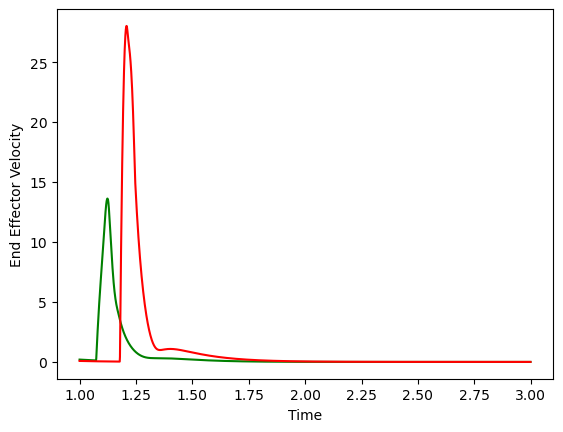


INFO:drake:Meshcat listening for connections at http://localhost:7004
==== LCM Warning ===
LCM detected that large packets are being received, but the kernel UDP
receive buffer is very small.  The possibility of dropping packets due to
insufficient buffer space is very high.

For more information, visit:
   http://lcm-proj.github.io/lcm/multicast_setup.html

KTO Trial #2: [ 0.87057252 -0.31390046  0.71220864]!
KTO solver succeeded in 0.026624679565429688 seconds.
KTO successfully hit target!

INFO:drake:Meshcat listening for connections at http://localhost:7005
==== LCM Warning ===
LCM detected that large packets are being received, but the kernel UDP
receive buffer is very small.  The possibility of dropping packets due to
insufficient buffer space is very high.

For more information, visit:
   http://lcm-proj.github.io/lcm/multicast_setup.html

IK Trial #2: [ 0.87057252 -0.31390046  0.71220864]!
IK solver succeeded in 0.0034818649291992188 seconds.
IK successfully hit target!


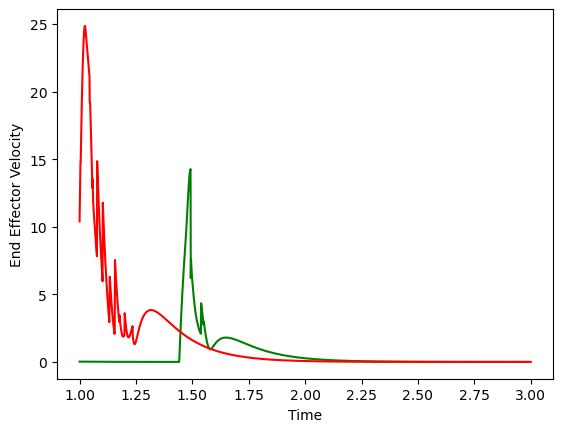


INFO:drake:Meshcat listening for connections at http://localhost:7006
KTO Trial #3: [0.72775804 0.40489102 0.79173406]!
KTO solver succeeded in 0.03577828407287598 seconds.
==== LCM Warning ===
LCM detected that large packets are being received, but the kernel UDP
receive buffer is very small.  The possibility of dropping packets due to
insufficient buffer space is very high.

For more information, visit:
   http://lcm-proj.github.io/lcm/multicast_setup.html

KTO... Mission failed, we'll get 'em next time!

INFO:drake:Meshcat listening for connections at http://localhost:7007
IK Trial #3: [0.72775804 0.40489102 0.79173406]!
IK solver succeeded in 0.003490924835205078 seconds.
==== LCM Warning ===
LCM detected that large packets are being received, but the kernel UDP
receive buffer is very small.  The possibility of dropping packets due to
insufficient buffer space is very high.

For more information, visit:
   http://lcm-proj.github.io/lcm/multicast_setup.html

IK successfully hit tar

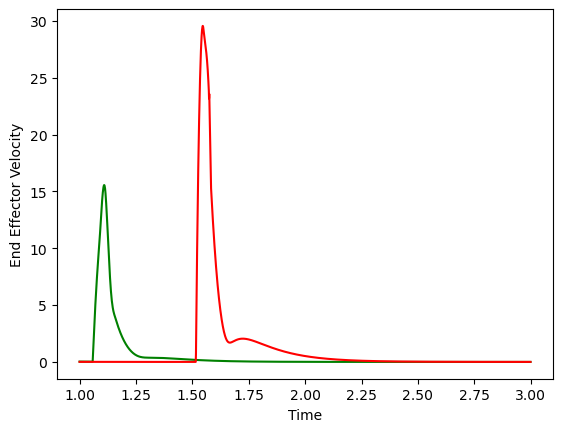


INFO:drake:Meshcat listening for connections at http://localhost:7008
==== LCM Warning ===
LCM detected that large packets are being received, but the kernel UDP
receive buffer is very small.  The possibility of dropping packets due to
insufficient buffer space is very high.

For more information, visit:
   http://lcm-proj.github.io/lcm/multicast_setup.html

KTO Trial #4: [ 0.84196181 -0.36694634  0.84063693]!
KTO solver succeeded in 0.09262442588806152 seconds.

KTO... Mission failed, we'll get 'em next time!
INFO:drake:Meshcat listening for connections at http://localhost:7009
IK Trial #4: [ 0.84196181 -0.36694634  0.84063693]!
0: Failed: SNOPT...
1: Failed: SNOPT...
2: Failed: SNOPT...
IK solver failed in 0.026397228240966797 seconds.
IK... Mission failed, we'll get 'em next time!


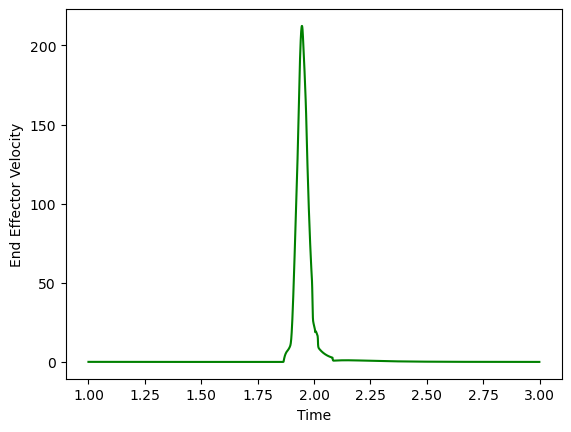


INFO:drake:Meshcat listening for connections at http://localhost:7010
==== LCM Warning ===
LCM detected that large packets are being received, but the kernel UDP
receive buffer is very small.  The possibility of dropping packets due to
insufficient buffer space is very high.

For more information, visit:
   http://lcm-proj.github.io/lcm/multicast_setup.html

==== LCM Warning ===
LCM detected that large packets are being received, but the kernel UDP
receive buffer is very small.  The possibility of dropping packets due to
insufficient buffer space is very high.

For more information, visit:
   http://lcm-proj.github.io/lcm/multicast_setup.html

KTO Trial #5: [0.71524763 0.39121023 0.8091275 ]!
KTO solver succeeded in 0.044966936111450195 seconds.
KTO successfully hit target!

INFO:drake:Meshcat listening for connections at http://localhost:7011
IK Trial #5: [0.71524763 0.39121023 0.8091275 ]!
IK solver succeeded in 0.004375934600830078 seconds.
==== LCM Warning ===
LCM detected that la

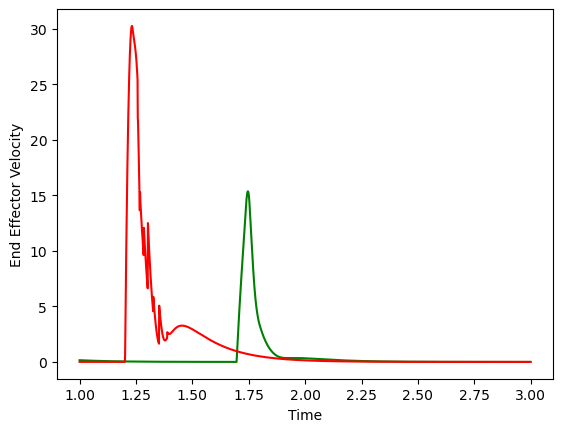


INFO:drake:Meshcat listening for connections at http://localhost:7012
==== LCM Warning ===
LCM detected that large packets are being received, but the kernel UDP
receive buffer is very small.  The possibility of dropping packets due to
insufficient buffer space is very high.

For more information, visit:
   http://lcm-proj.github.io/lcm/multicast_setup.html

KTO Trial #6: [ 0.85282463 -0.46285309  0.79236008]!
KTO solver succeeded in 0.07349514961242676 seconds.

KTO successfully hit target!
INFO:drake:Meshcat listening for connections at http://localhost:7013
IK Trial #6: [ 0.85282463 -0.46285309  0.79236008]!
0: Failed: SNOPT...
1: Failed: SNOPT...
2: Failed: SNOPT...
IK solver failed in 0.016364336013793945 seconds.
IK... Mission failed, we'll get 'em next time!


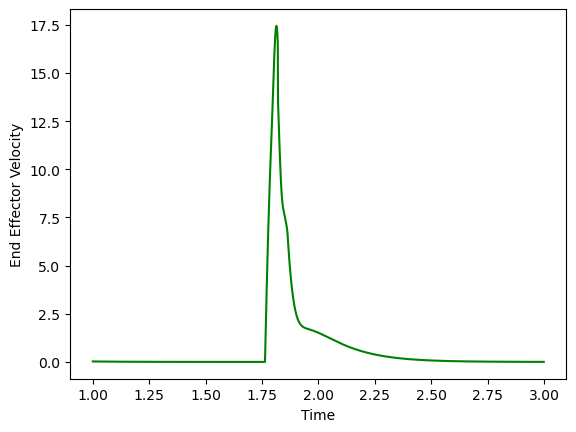


INFO:drake:Meshcat listening for connections at http://localhost:7014
KTO Trial #7: [0.83991209 0.35593897 0.70417759]!
KTO solver succeeded in 0.05790114402770996 seconds.
==== LCM Warning ===
LCM detected that large packets are being received, but the kernel UDP
receive buffer is very small.  The possibility of dropping packets due to
insufficient buffer space is very high.

For more information, visit:
   http://lcm-proj.github.io/lcm/multicast_setup.html

==== LCM Warning ===
LCM detected that large packets are being received, but the kernel UDP
receive buffer is very small.  The possibility of dropping packets due to
insufficient buffer space is very high.

For more information, visit:
   http://lcm-proj.github.io/lcm/multicast_setup.html

KTO successfully hit target!

INFO:drake:Meshcat listening for connections at http://localhost:7015
==== LCM Warning ===
LCM detected that large packets are being received, but the kernel UDP
receive buffer is very small.  The possibility of dr

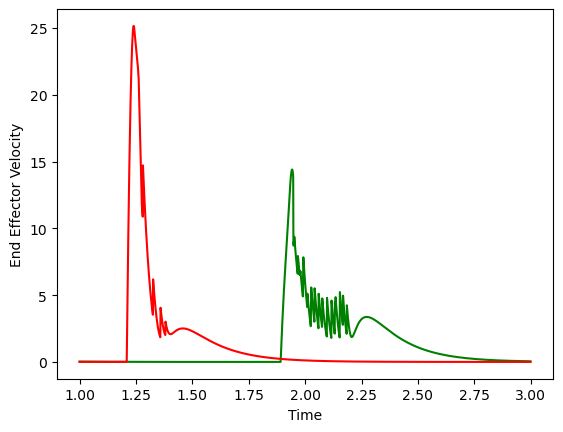


INFO:drake:Meshcat listening for connections at http://localhost:7016
KTO Trial #8: [ 0.74565623 -0.32775636  0.74711399]!
KTO solver succeeded in 0.03320956230163574 seconds.
==== LCM Warning ===
LCM detected that large packets are being received, but the kernel UDP
receive buffer is very small.  The possibility of dropping packets due to
insufficient buffer space is very high.

For more information, visit:
   http://lcm-proj.github.io/lcm/multicast_setup.html

KTO... Mission failed, we'll get 'em next time!

INFO:drake:Meshcat listening for connections at http://localhost:7017
IK Trial #8: [ 0.74565623 -0.32775636  0.74711399]!
IK solver succeeded in 0.005154848098754883 seconds.
==== LCM Warning ===
LCM detected that large packets are being received, but the kernel UDP
receive buffer is very small.  The possibility of dropping packets due to
insufficient buffer space is very high.

For more information, visit:
   http://lcm-proj.github.io/lcm/multicast_setup.html

IK successfully h

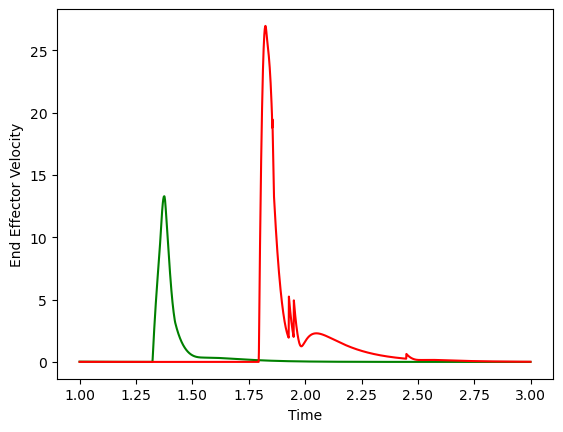


INFO:drake:Meshcat listening for connections at http://localhost:7018
==== LCM Warning ===
LCM detected that large packets are being received, but the kernel UDP
receive buffer is very small.  The possibility of dropping packets due to
insufficient buffer space is very high.

For more information, visit:
   http://lcm-proj.github.io/lcm/multicast_setup.html

KTO Trial #9: [ 0.84850361 -0.48935939  0.73898249]!
KTO solver succeeded in 0.0239255428314209 seconds.

KTO successfully hit target!
INFO:drake:Meshcat listening for connections at http://localhost:7019
IK Trial #9: [ 0.84850361 -0.48935939  0.73898249]!
0: Failed: SNOPT...
1: Failed: SNOPT...
2: Failed: SNOPT...
IK solver failed in 0.018943071365356445 seconds.
IK... Mission failed, we'll get 'em next time!


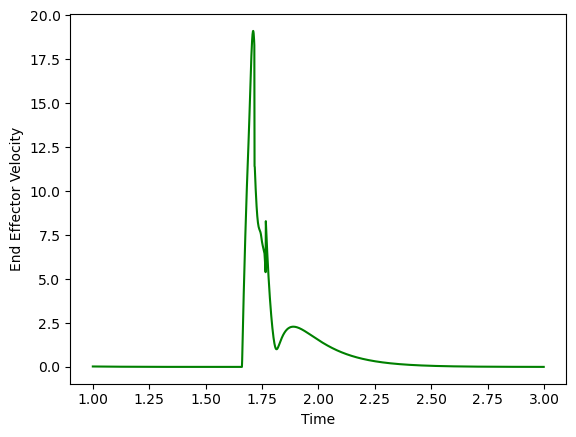


INFO:drake:Meshcat listening for connections at http://localhost:7020
KTO Trial #10: [0.817686   0.38897545 0.71761067]!
KTO solver succeeded in 0.03611302375793457 seconds.
==== LCM Warning ===
LCM detected that large packets are being received, but the kernel UDP
receive buffer is very small.  The possibility of dropping packets due to
insufficient buffer space is very high.

For more information, visit:
   http://lcm-proj.github.io/lcm/multicast_setup.html

==== LCM Warning ===
LCM detected that large packets are being received, but the kernel UDP
receive buffer is very small.  The possibility of dropping packets due to
insufficient buffer space is very high.

For more information, visit:
   http://lcm-proj.github.io/lcm/multicast_setup.html

KTO successfully hit target!

INFO:drake:Meshcat listening for connections at http://localhost:7021
IK Trial #10: [0.817686   0.38897545 0.71761067]!
IK solver succeeded in 0.003586292266845703 seconds.
==== LCM Warning ===
LCM detected that l

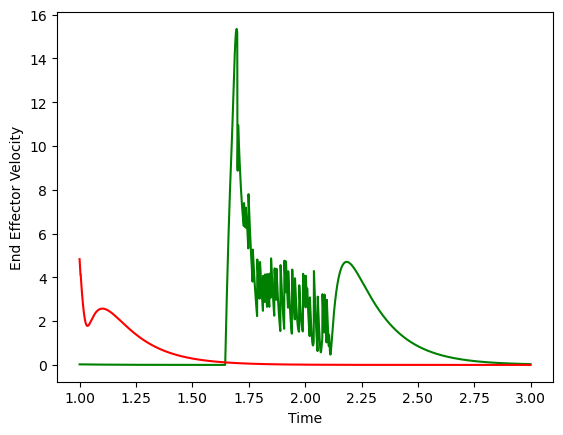


INFO:drake:Meshcat listening for connections at http://localhost:7022
==== LCM Warning ===
LCM detected that large packets are being received, but the kernel UDP
receive buffer is very small.  The possibility of dropping packets due to
insufficient buffer space is very high.

For more information, visit:
   http://lcm-proj.github.io/lcm/multicast_setup.html

KTO Trial #11: [ 0.83892082 -0.4458727   0.75667264]!
KTO solver succeeded in 0.05538630485534668 seconds.

KTO successfully hit target!
INFO:drake:Meshcat listening for connections at http://localhost:7023
IK Trial #11: [ 0.83892082 -0.4458727   0.75667264]!
0: Failed: SNOPT...
1: Failed: SNOPT...
2: Failed: SNOPT...
IK solver failed in 0.010581731796264648 seconds.
IK... Mission failed, we'll get 'em next time!


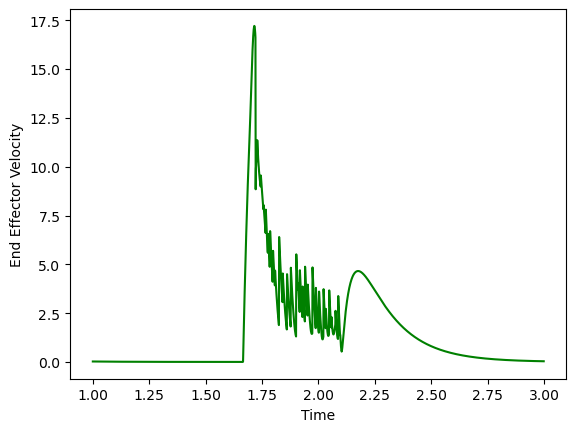


INFO:drake:Meshcat listening for connections at http://localhost:7024
==== LCM Warning ===
LCM detected that large packets are being received, but the kernel UDP
receive buffer is very small.  The possibility of dropping packets due to
insufficient buffer space is very high.

For more information, visit:
   http://lcm-proj.github.io/lcm/multicast_setup.html

KTO Trial #12: [0.78009123 0.41973196 0.75507594]!
KTO solver succeeded in 0.12372279167175293 seconds.
==== LCM Warning ===
LCM detected that large packets are being received, but the kernel UDP
receive buffer is very small.  The possibility of dropping packets due to
insufficient buffer space is very high.

For more information, visit:
   http://lcm-proj.github.io/lcm/multicast_setup.html

KTO... Mission failed, we'll get 'em next time!

INFO:drake:Meshcat listening for connections at http://localhost:7025
==== LCM Warning ===
LCM detected that large packets are being received, but the kernel UDP
receive buffer is very small.  T

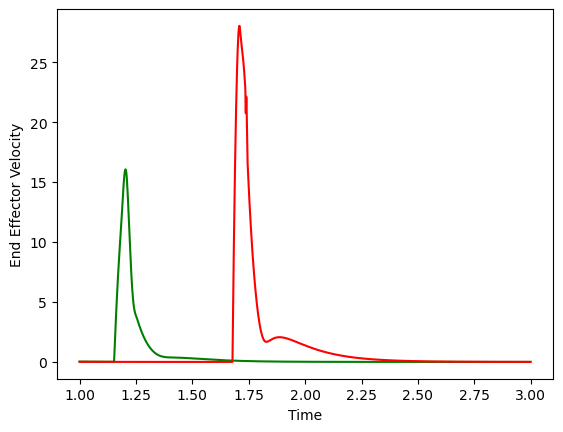


INFO:drake:Meshcat listening for connections at http://localhost:7026
KTO Trial #13: [ 0.78736649 -0.38101709  0.82268224]!
KTO solver succeeded in 0.11406540870666504 seconds.
==== LCM Warning ===
LCM detected that large packets are being received, but the kernel UDP
receive buffer is very small.  The possibility of dropping packets due to
insufficient buffer space is very high.

For more information, visit:
   http://lcm-proj.github.io/lcm/multicast_setup.html


KTO successfully hit target!
INFO:drake:Meshcat listening for connections at http://localhost:7027
IK Trial #13: [ 0.78736649 -0.38101709  0.82268224]!
0: Failed: SNOPT...
1: Failed: SNOPT...
2: Failed: SNOPT...
IK solver failed in 0.02664923667907715 seconds.
IK... Mission failed, we'll get 'em next time!


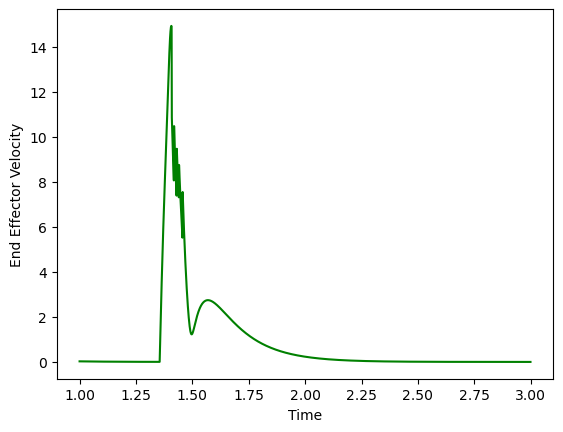


INFO:drake:Meshcat listening for connections at http://localhost:7028
==== LCM Warning ===
LCM detected that large packets are being received, but the kernel UDP
receive buffer is very small.  The possibility of dropping packets due to
insufficient buffer space is very high.

For more information, visit:
   http://lcm-proj.github.io/lcm/multicast_setup.html

KTO Trial #14: [0.74619971 0.37101975 0.85206505]!
KTO solver succeeded in 0.04035782814025879 seconds.
==== LCM Warning ===
LCM detected that large packets are being received, but the kernel UDP
receive buffer is very small.  The possibility of dropping packets due to
insufficient buffer space is very high.

For more information, visit:
   http://lcm-proj.github.io/lcm/multicast_setup.html

KTO... Mission failed, we'll get 'em next time!

INFO:drake:Meshcat listening for connections at http://localhost:7029
IK Trial #14: [0.74619971 0.37101975 0.85206505]!
0: Failed: SNOPT...
1: Failed: SNOPT...
2: Failed: SNOPT...
IK solver fail

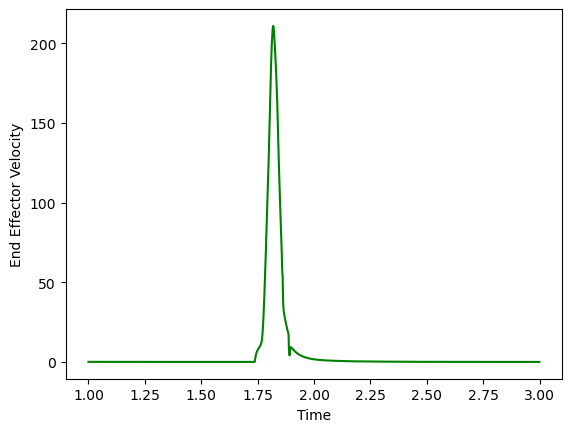


INFO:drake:Meshcat listening for connections at http://localhost:7030
==== LCM Warning ===
LCM detected that large packets are being received, but the kernel UDP
receive buffer is very small.  The possibility of dropping packets due to
insufficient buffer space is very high.

For more information, visit:
   http://lcm-proj.github.io/lcm/multicast_setup.html

==== LCM Warning ===
LCM detected that large packets are being received, but the kernel UDP
receive buffer is very small.  The possibility of dropping packets due to
insufficient buffer space is very high.

For more information, visit:
   http://lcm-proj.github.io/lcm/multicast_setup.html

KTO Trial #15: [0.77037473 0.4743584  0.82015403]!
KTO solver succeeded in 0.04019045829772949 seconds.
KTO successfully hit target!

INFO:drake:Meshcat listening for connections at http://localhost:7031
IK Trial #15: [0.77037473 0.4743584  0.82015403]!
0: Failed: SNOPT...
1: Failed: SNOPT...
2: Failed: SNOPT...
IK solver failed in 0.01148009300

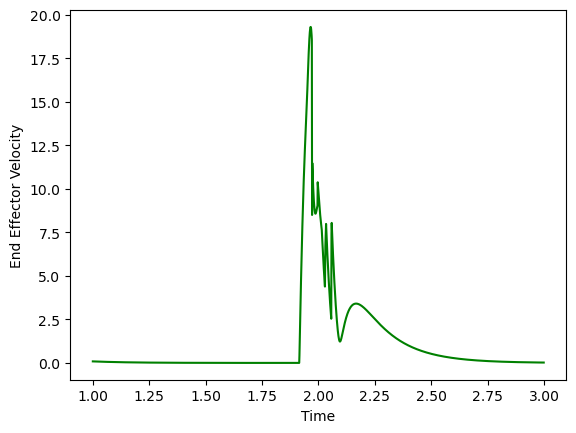


INFO:drake:Meshcat listening for connections at http://localhost:7032
KTO Trial #16: [ 0.7988337  -0.42318374  0.83270783]!
KTO solver succeeded in 0.09989643096923828 seconds.
==== LCM Warning ===
LCM detected that large packets are being received, but the kernel UDP
receive buffer is very small.  The possibility of dropping packets due to
insufficient buffer space is very high.

For more information, visit:
   http://lcm-proj.github.io/lcm/multicast_setup.html

==== LCM Warning ===
LCM detected that large packets are being received, but the kernel UDP
receive buffer is very small.  The possibility of dropping packets due to
insufficient buffer space is very high.

For more information, visit:
   http://lcm-proj.github.io/lcm/multicast_setup.html


KTO successfully hit target!
INFO:drake:Meshcat listening for connections at http://localhost:7033
IK Trial #16: [ 0.7988337  -0.42318374  0.83270783]!
0: Failed: SNOPT...
1: Failed: SNOPT...
2: Failed: SNOPT...
IK solver failed in 0.02333

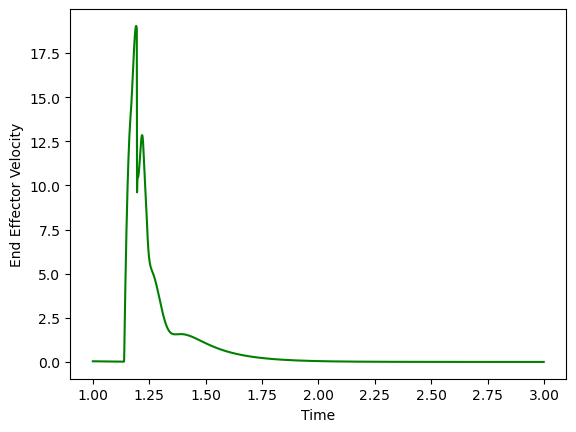


INFO:drake:Meshcat listening for connections at http://localhost:7034
KTO Trial #17: [ 0.74440495 -0.45202604  0.86743994]!
KTO solver succeeded in 0.016269445419311523 seconds.
==== LCM Warning ===
LCM detected that large packets are being received, but the kernel UDP
receive buffer is very small.  The possibility of dropping packets due to
insufficient buffer space is very high.

For more information, visit:
   http://lcm-proj.github.io/lcm/multicast_setup.html

==== LCM Warning ===
LCM detected that large packets are being received, but the kernel UDP
receive buffer is very small.  The possibility of dropping packets due to
insufficient buffer space is very high.

For more information, visit:
   http://lcm-proj.github.io/lcm/multicast_setup.html

KTO successfully hit target!

INFO:drake:Meshcat listening for connections at http://localhost:7035
IK Trial #17: [ 0.74440495 -0.45202604  0.86743994]!
0: Failed: SNOPT...
1: Failed: SNOPT...
2: Failed: SNOPT...
IK solver failed in 0.0190

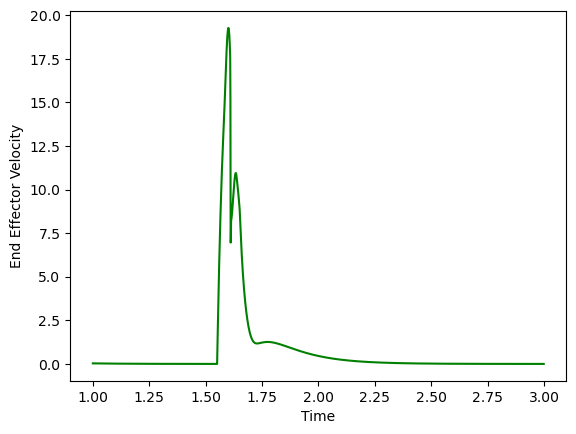


INFO:drake:Meshcat listening for connections at http://localhost:7036
KTO Trial #18: [ 0.80603902 -0.46195266  0.83394175]!
KTO solver succeeded in 0.02186870574951172 seconds.
==== LCM Warning ===
LCM detected that large packets are being received, but the kernel UDP
receive buffer is very small.  The possibility of dropping packets due to
insufficient buffer space is very high.

For more information, visit:
   http://lcm-proj.github.io/lcm/multicast_setup.html

==== LCM Warning ===
LCM detected that large packets are being received, but the kernel UDP
receive buffer is very small.  The possibility of dropping packets due to
insufficient buffer space is very high.

For more information, visit:
   http://lcm-proj.github.io/lcm/multicast_setup.html

KTO successfully hit target!

INFO:drake:Meshcat listening for connections at http://localhost:7037
IK Trial #18: [ 0.80603902 -0.46195266  0.83394175]!
0: Failed: SNOPT...
1: Failed: SNOPT...
2: Failed: SNOPT...
IK solver failed in 0.02497

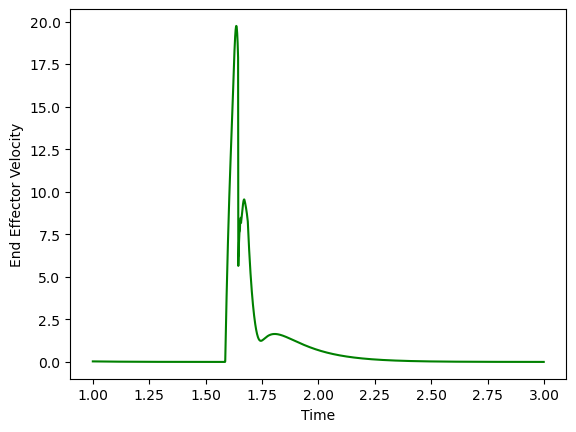


INFO:drake:Meshcat listening for connections at http://localhost:7038
==== LCM Warning ===
LCM detected that large packets are being received, but the kernel UDP
receive buffer is very small.  The possibility of dropping packets due to
insufficient buffer space is very high.

For more information, visit:
   http://lcm-proj.github.io/lcm/multicast_setup.html

KTO Trial #19: [ 0.77510339 -0.37546397  0.72463468]!
KTO solver succeeded in 0.01865839958190918 seconds.
==== LCM Warning ===
LCM detected that large packets are being received, but the kernel UDP
receive buffer is very small.  The possibility of dropping packets due to
insufficient buffer space is very high.

For more information, visit:
   http://lcm-proj.github.io/lcm/multicast_setup.html

KTO successfully hit target!

INFO:drake:Meshcat listening for connections at http://localhost:7039
==== LCM Warning ===
LCM detected that large packets are being received, but the kernel UDP
receive buffer is very small.  The possibility o

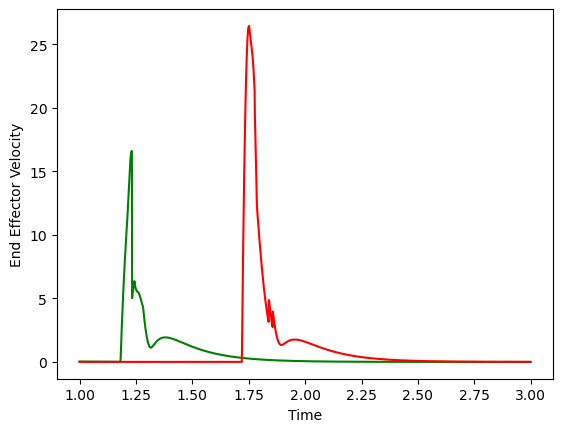


INFO:drake:Meshcat listening for connections at http://localhost:7040
==== LCM Warning ===
LCM detected that large packets are being received, but the kernel UDP
receive buffer is very small.  The possibility of dropping packets due to
insufficient buffer space is very high.

For more information, visit:
   http://lcm-proj.github.io/lcm/multicast_setup.html

KTO Trial #20: [ 0.7592012  -0.48653241  0.77116897]!
KTO solver succeeded in 0.02036762237548828 seconds.
KTO successfully hit target!

INFO:drake:Meshcat listening for connections at http://localhost:7041
IK Trial #20: [ 0.7592012  -0.48653241  0.77116897]!
0: Failed: SNOPT...
1: Failed: SNOPT...
2: Failed: SNOPT...
IK solver failed in 0.04921460151672363 seconds.
IK... Mission failed, we'll get 'em next time!


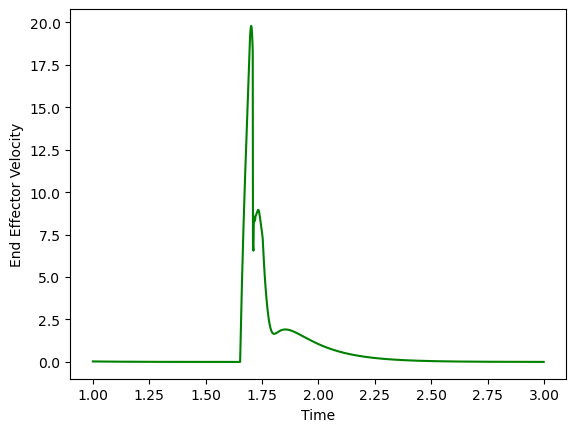

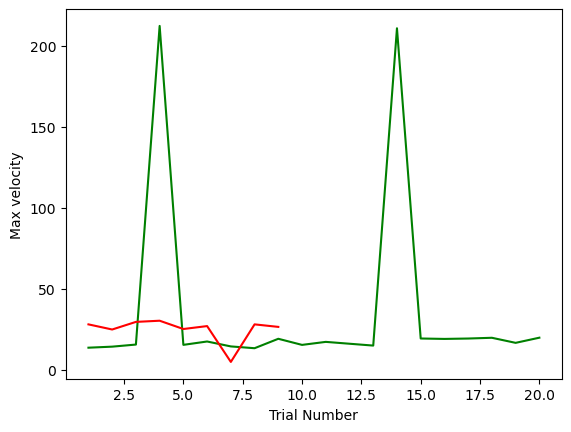

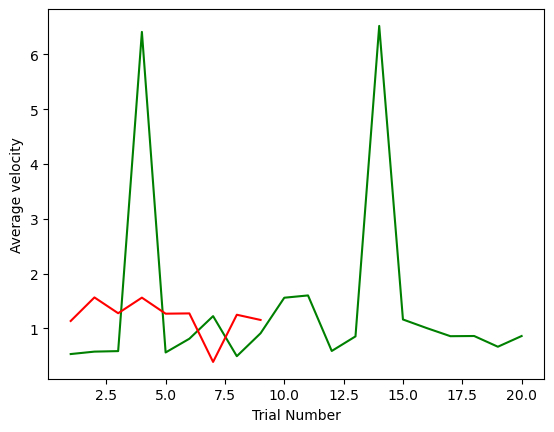

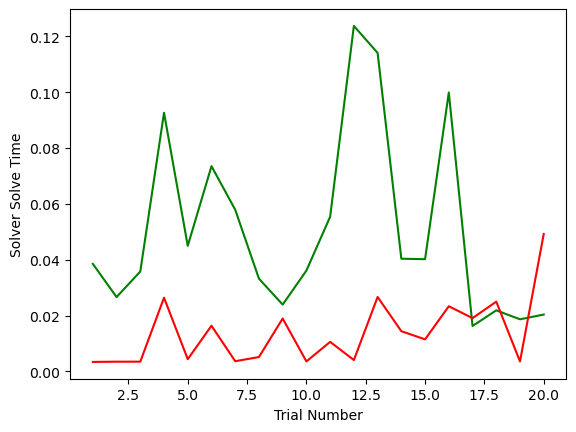

KTO solver score: 75.0%
IK solver score: 45.0%
Done!


In [ ]:
# initialize ninja robot.
print("Creating ninja!")
ninja = Ninja(scenario_no_ballz, meshcat)

ninja.builder = DiagramBuilder()
ninja.station = ninja.builder.AddSystem(MakeHardwareStation(ninja.scenario))
ninja.plant = ninja.station.GetSubsystemByName("plant")
ninja.scene_graph = ninja.station.GetSubsystemByName("scene_graph")

ninja.visualizer = MeshcatVisualizer.AddToBuilder(
    ninja.builder,
    ninja.station.GetOutputPort("query_object"),
    ninja.meshcat,
    MeshcatVisualizerParams(delete_on_initialization_event=False),
)

ninja.diagram = ninja.builder.Build()

ninja.diagram_context = ninja.diagram.CreateDefaultContext()
ninja.plant_context = ninja.plant.CreateDefaultContext()
ninja.katana = ninja.plant.GetBodyByName("katana")
ninja.world_frame = ninja.plant.world_frame()
ninja.katana_frame = ninja.plant.GetFrameByName("katana")

ninja.initial_pose = ninja.plant.EvalBodyPoseInWorld(ninja.plant_context, ninja.katana)

print("Created ninja!")

trials = 20

num_solvers = 2
KTO = "KTO"
IK = "IK"
solvers = [KTO, IK]
solver_times = [[] for i in range(num_solvers)]
hits = [0 for i in range(num_solvers)]
max_velocities = [[] for i in range(num_solvers)]
avg_velocities = [[] for i in range(num_solvers)]

print("Starting trials!")
for trial_num in range(trials):
    # do random generation all the way up here, before the dojo is built!
    x = np.random.uniform(-0.1, 0.1)
    y = np.random.uniform(0.3, 0.5) * (1 if np.random.random() < 0.5 else -1)
    z = np.random.uniform(-0.1, 0.1)

    for solver_num in range(num_solvers):
        # initialize the dojo!
        dojo = Ninja(scenario, meshcat)

        dojo.builder = DiagramBuilder()
        dojo.station = dojo.builder.AddSystem(MakeHardwareStation(dojo.scenario))
        dojo.plant = dojo.station.GetSubsystemByName("plant")
        dojo.scene_graph = dojo.station.GetSubsystemByName("scene_graph")

        dojo.visualizer = MeshcatVisualizer.AddToBuilder(
            dojo.builder,
            dojo.station.GetOutputPort("query_object"),
            dojo.meshcat,
            MeshcatVisualizerParams(delete_on_initialization_event=False),
        )

        dojo.plant_context = dojo.plant.CreateDefaultContext()
        dojo.katana = dojo.plant.GetBodyByName("katana")
        dojo.world_frame = dojo.plant.world_frame()
        dojo.katana_frame = dojo.plant.GetFrameByName("katana")

        dojo.initial_pose = dojo.plant.EvalBodyPoseInWorld(dojo.plant_context, dojo.katana)
        
        ### TENNO HEIKA BANZAI
        p0 = np.array(ninja.initial_pose.translation())

        g = -9.8
        lower_bound = 0.1
        i = 0
        p = p0 + np.array([x, y, z])

        dest_x, dest_y, dest_z = p[0], p[1], p[2]

        # initial positions
        fgp_x, fgp_y, fgp_z = 1, random.uniform(-2, 2), -3

        # initial velocities - calculated w kinematics
        # randomly generate initial z velocity - determines arc
        # can solve for x velocity as we need to hit destination value at the same time for all coordinates
        # can solve for time from x velocity, which will then give us the y velocity
        #vi_x, vi_y, vi_z = -5, .3, 5
        v0_z_min = (2*g*(fgp_z-dest_z))**.5 # min velo for fruit to reach robot
        v0_z = random.uniform(v0_z_min, v0_z_min+3)
        v0_x = (g*(dest_x - fgp_x)) / (-v0_z - (v0_z**2 - 2*g*(fgp_z - dest_z))**.5)
        t = (dest_x - fgp_x) / v0_x
        v0_y = (dest_y - fgp_y) / t

        print(f"{solvers[solver_num]} Trial #{trial_num+1}: {p}!")
        trajectory = create_cut_trajectory(ninja, [p])
        solve_start_time = time.time()
        
        if solvers[solver_num] == IK:
            qs, times = ninja.create_ik_trajectory(trajectory, [lower_bound, 5], 3)
        else:
            qs, times = ninja.create_kinematic_trajectory(trajectory, num_trajectory_samples, [lower_bound, 5], 3)

        solve_end_time = time.time()
        solver_times[solver_num].append(solve_end_time - solve_start_time)
        hit = False

        if len(qs) <= 0 or len(times) <= 0:
            print(f"{solvers[solver_num]} solver failed in {solve_end_time - solve_start_time} seconds.")
        else:
            print(f"{solvers[solver_num]} solver succeeded in {solve_end_time - solve_start_time} seconds.")
            ninja.context = ninja.plant.CreateDefaultContext()
            closest_traj_dist = np.inf
            closest_traj_dist_index = 0
            closest_pose = None

            for i in range(len(qs)):
                ninja.plant.SetPositions(ninja.context, qs[i])
                katana_pose = ninja.plant.CalcRelativeTransform(ninja.context, ninja.plant.world_frame(), ninja.katana_frame)
                if np.linalg.norm(np.array(katana_pose.translation()) - p) < closest_traj_dist:
                    closest_traj_dist_index = i
                    closest_pose = katana_pose
                    closest_traj_dist = np.linalg.norm(np.array(katana_pose.translation()) - p)
                # color = Rgba(1, 1, 0, 0.8)
                # meshcat.SetObject(str(i) + "t", Sphere(0.01), rgba=color)
                # meshcat.SetTransform(str(i) + "t", closest_pose)

            dest_time = closest_traj_dist_index * (times[-1] - times[0])/len(qs)
            shifted_times = times + (t - dest_time) - 0.05

            # color = Rgba(1, 1, 1, 0.8)
            # meshcat.SetObject("himothy", Sphere(0.015), rgba=color)
            # meshcat.SetTransform("himothy", closest_pose)

            # connect and run
            q_traj = PiecewisePolynomial.CubicShapePreserving(shifted_times, qs.T)
            q_traj_system = dojo.builder.AddSystem(TrajectorySource(q_traj))
            dojo.builder.Connect(q_traj_system.get_output_port(), dojo.station.GetInputPort("iiwa.position"))

            dojo.diagram = dojo.builder.Build()
            dojo.simulator = Simulator(dojo.diagram)

            context = dojo.simulator.get_mutable_context()
            plant_context = dojo.plant.GetMyContextFromRoot(context)
            scene_graph_context = dojo.diagram.GetMutableSubsystemContext(
                dojo.scene_graph, 
                context
            )

            # Set the position of the object
            desired_position1 = np.array([0, np.sqrt(2)/2, 0, np.sqrt(2)/2, fgp_x, fgp_y, fgp_z])  # rotated
            desired_position2 = np.array([0, -np.sqrt(2)/2, 0, np.sqrt(2)/2, fgp_x, fgp_y, fgp_z]) 
            desired_velocity = np.array([0, 0, 0, v0_x, v0_y, v0_z]) # straight up first

            ci = 0

            dojo.plant.SetPositions(plant_context, dojo.plant.GetModelInstanceByName(f"half_{colors[ci]}1"), desired_position1)
            dojo.plant.SetPositions(plant_context, dojo.plant.GetModelInstanceByName(f"half_{colors[ci]}2"), desired_position2)
            dojo.plant.SetVelocities(plant_context, dojo.plant.GetModelInstanceByName(f"half_{colors[ci]}1"), desired_velocity)
            dojo.plant.SetVelocities(plant_context, dojo.plant.GetModelInstanceByName(f"half_{colors[ci]}2"), desired_velocity)

            dojo.visualizer.StartRecording()

            # dojo.plant.set_contact_model("point")

            dt = .001
            now = dojo.simulator.get_context().get_time()
            timesteps = []
            katana_velocities = []
            while now < 4:
                query_object = dojo.scene_graph.get_query_output_port().Eval(scene_graph_context)
                collision_pairs = query_object.ComputePointPairPenetration()

                body1 = dojo.plant.GetBodyByName("katana")
                body2 = dojo.plant.GetBodyByName("half_green1")
                body3 = dojo.plant.GetBodyByName("half_green2")
                for pair in collision_pairs:
                    if not hit:
                        hit = True
                    v = np.array([0, 0, 0, random.uniform(-1, 1), random.uniform(-1, 1), 2])
                    dojo.plant.SetVelocities(plant_context, dojo.plant.GetModelInstanceByName("half_"+colors[ci]+"1"), v)
                    dojo.plant.SetVelocities(plant_context, dojo.plant.GetModelInstanceByName("half_"+colors[ci]+"2"), -v)

                Jacobian = dojo.plant.CalcJacobianSpatialVelocity(
                    plant_context, 
                    JacobianWrtVariable.kV,
                    dojo.katana_frame, 
                    np.zeros(3),
                    dojo.world_frame, 
                    dojo.katana_frame
                )

                # Get the joint velocities
                joint_velocities = dojo.plant.GetVelocities(plant_context)

                # Compute the spatial velocity of the end effector
                end_effector_velocity = Jacobian.dot(joint_velocities)
                timesteps.append(now)
                katana_velocities.append(np.linalg.norm(end_effector_velocity))
                
                dojo.simulator.AdvanceTo(now+dt)
                now = dojo.simulator.get_context().get_time()

            dojo.visualizer.PublishRecording()

            plot_start = 1000
            plot_end = 3000
            plot_line = "r-" if solvers[solver_num] == IK else "g-"
            plt.plot(timesteps[plot_start:plot_end], katana_velocities[plot_start:plot_end], plot_line)

            max_velocities[solver_num].append(np.max(katana_velocities[plot_start:plot_end]))
            avg_velocities[solver_num].append(np.average(katana_velocities[plot_start:plot_end]))
            
        if hit:
            print(f"{solvers[solver_num]} successfully hit target!")
        else:
            print(f"{solvers[solver_num]}... Mission failed, we'll get 'em next time!")
        hits[solver_num] += int(hit)

    plt.xlabel("Time")
    plt.ylabel("End Effector Velocity")
    plt.show()

for solver_num in range(num_solvers):
    plot_line = "r-" if solvers[solver_num] == IK else "g-"
    plt.plot([i+1 for i in range(len(max_velocities[solver_num]))], max_velocities[solver_num], plot_line)
plt.xlabel("Trial Number")
plt.ylabel("Max velocity")
plt.show()

for solver_num in range(num_solvers):
    plot_line = "r-" if solvers[solver_num] == IK else "g-"
    plt.plot([i+1 for i in range(len(avg_velocities[solver_num]))], avg_velocities[solver_num], plot_line)
plt.xlabel("Trial Number")
plt.ylabel("Average velocity")
plt.show()

for solver_num in range(num_solvers):
    plot_line = "r-" if solvers[solver_num] == IK else "g-"
    plt.plot([i+1 for i in range(len(solver_times[solver_num]))], solver_times[solver_num], plot_line)
plt.xlabel("Trial Number")
plt.ylabel("Solver Solve Time")
plt.show()

for solver_num in range(num_solvers):
    print(f"{solvers[solver_num]} solver score: {hits[solver_num]/trials * 100}%")

print("Done!")

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f7bf94ae-48b6-4da0-b037-4d9acdec7e95' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>